```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - PM2.5 - Time Series Cross Validation

## Contents

- [Time series cross validation](#tscv)
- [Load daily data](#data_d)
- [Time series cross validation example](#tscv)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from model import (
    split_df_for_ts_modelling_date_range
)

from model import (
    get_pm25_data_for_modelling,
    split_df_for_ml_modelling,
    get_models_for_regression
)

from measure import (
    get_rmse,
    score_ml_models
)

from plot import (
    plot_observed_vs_predicted
)

---
<a id='tscv'></a>

## Time series cross validation

Always validate your cross validation by visualizing it.

Because time series data is not `independent identically distributed (i.i.d.)` we cannot use the standard cross validation techniques and randomized assignment of observations to different folds (folds = blocks/chunks). To trust a score of a time series model, it is crutial to ensure that the training set does not exist in the validation set. For `time series cross validation`, we must use a technique that always use training data from the past to predict the future - the training data must always comes before the validation data.

`TimeSeriesSplit` is a variation of k-fold which returns first folds as train set and the n-th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model. This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

<img src="images/ts_split_cv.png" style="width: 800px;"/>
From [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

### Walk Forward Validation
Walk Forward Validation procedure:

1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to step 1.)

Because this methodology involves moving along the time series one-time step at a time, it is often called `Walk Forward Testing` or `Walk Forward Validation`. Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as `Rolling Window Analysis` or a `Rolling Forecast`.

`Walk forward validation` is the gold standard of model evaluation. It is the k-fold cross validation of the time series world and is recommended for your time series projects. This capability is currently not available in scikit-learn, although you could contrive the same effect with a carefully configured `TimeSeriesSplit`.

---
<a id='data_d'></a>

## Load daily data

In [7]:
df = get_pm25_data_for_modelling('ts', 'd')
df.head()

common.py | 42 | get_pm25_data_for_modelling | 08-Jun-20 16:19:58 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 08-Jun-20 16:19:58 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


---
<a id='data_d'></a>

## Time series cross validation example

In [8]:
#df = df[-365:].copy()
#df = df.reset_index(drop=True)

train_range_from_d = '2008-01-01'
train_range_to_d = '2018-12-25'
test_range_from_d = '2018-12-26'
test_range_to_d = None

In [9]:
df_train, df_test = split_df_for_ts_modelling_date_range(df,
                                         train_range_from=train_range_from_d,
                                         train_range_to=train_range_to_d,
                                         test_range_from=test_range_from_d,
                                         test_range_to=test_range_to_d)

common.py | 127 | split_df_for_ts_modelling_date_range | 08-Jun-20 16:20:01 | INFO: Observations: 4019
common.py | 128 | split_df_for_ts_modelling_date_range | 08-Jun-20 16:20:01 | INFO: Training Observations: 4012
common.py | 129 | split_df_for_ts_modelling_date_range | 08-Jun-20 16:20:01 | INFO: Testing Observations: 7
common.py | 131 | split_df_for_ts_modelling_date_range | 08-Jun-20 16:20:01 | INFO: (4019, 1), (4012, 1), (7, 1), 4019


Observations: 2006
Training Observations: 1003
Testing Observations: 1003
Observations: 3009
Training Observations: 2006
Testing Observations: 1003
Observations: 4012
Training Observations: 3009
Testing Observations: 1003


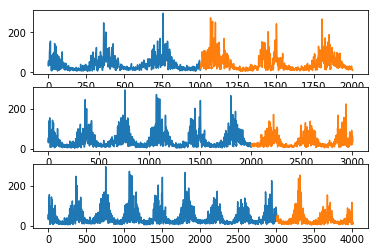

In [10]:
#from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
#from matplotlib import pyplot
#series = read_csv('sunspots.csv', header=0, index_col=0)
series = df_train
X = series.values
splits = TimeSeriesSplit(n_splits=3)
plt.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()